In [ ]:
%%capture
!pip install NeuralForecast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,6)
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, TimesNet
from neuralforecast.losses.numpy import mae, mse


In [ ]:
%%capture
data = pd.read_csv('https://raw.githubusercontent.com/CSID-DGU/2024-1-DSCD-LAST_DANCE-2/d07486522d177725cd1e6972aa57da7ac6dd5e65/data/%EC%88%98%EC%9D%B5%EB%A5%A0test.csv')
data = data.iloc[:,1:]
# import yfinance as yf
# ticker = '005930.KS'  #005930.KS (삼성) 000660 (하이닉스)
# data = yf.download(tickers=ticker, period="730d", interval="1h")
###
for i in range(len(data['Volume'])):
  if data['Volume'][i] == 0:
    data['Volume'][i] = data['Volume'][i+1] * 2
  else:
    pass
data = data.reset_index()
data=data.rename(columns={"Datetime":"ds", "Close":"y"})
data['unique_id'] = 'BE'
data['ds'] = np.arange(len(data))
### Feature 조합
# Open - Close 열 생성
data['O-C'] = data['Open'] - data['y']
# High - Low 열 생성
data['H-L'] = data['High'] - data['Low']
# 2시간 이동평균선 열 생성
data['2Hr_MA'] = data['y'].rolling(window=2).mean()
# 4시간 이동평균선 열 생성
data['4Hr_MA'] = data['y'].rolling(window=4).mean() # 18
# 6시간 이동평균선 열 생성
data['6Hr_MA'] = data['y'].rolling(window=6).mean()  # 12
# 12시간 이동평균선 열 생성
data['12Hr_MA'] = data['y'].rolling(window=12).mean()  # 12
# 18시간 이동평균선 열 생성
data['18Hr_MA'] = data['y'].rolling(window=18).mean()  # 12
# # 6시간 이동평균선 열 생성
data['6Hr_MA'] = data['y'].rolling(window=6).mean()  # 12
# 2시간의 주가의 표쥰편차
data['2Hr_Std'] = data['y'].rolling(window = 4).std()
# 1의 자리 까지만
# data['2Hr_MA'] = data['2Hr_MA'].round(1)
# data['4Hr_MA'] = data['4Hr_MA'].round(1)
data['6Hr_MA'] = data['6Hr_MA'].round(1)
# data['2Hr_Std'] = data['2Hr_Std'].round(1)
# data['6Hr_Std'] = data['6Hr_Std'].round(1)
# Stochastic Oscillator
data['FastSO_18'] = ((data['y'] - data['Low'].rolling(window = 18).min()) / (data['High'].rolling(window = 18).max() - data['Low'].rolling(window = 18).min())) * 100 # 12
data['SlowSO_18'] = data['FastSO_18'].rolling(window = 6).mean()
data['FastSO_12'] = ((data['y'] - data['Low'].rolling(window = 12).min()) / (data['High'].rolling(window = 12).max() - data['Low'].rolling(window = 12).min())) * 100 # 12
data['SlowSO_12'] = data['FastSO_12'].rolling(window = 3).mean()
# CCI
def cci(data, window=3):
    typical_price = (data['High'] + data['Low'] + data['y']) / 3
    sma = typical_price.rolling(window=window).mean()
    mean_deviation = abs(typical_price - sma).rolling(window=window).mean()
    cci = (typical_price - sma) / (0.015 * mean_deviation)
    return cci
data['CCI_12'] = cci(data, window = 12) # 12
data['CCI_6'] = cci(data, window = 6) # 12
# data.drop(columns=['Open', 'High', 'Low', 'Adj Close'], inplace=True)
data = data[['ds','y','unique_id','O-C','18Hr_MA','H-L','SlowSO_18','FastSO_12','CCI_12','Volume','CCI_6']]
### 데이터셋 나누기
f_data = data.iloc[2712:,:]
actual = data.iloc[2712:,:]
data = data.iloc[22:2712,:]

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/CSID-DGU/2024-1-DSCD-LAST_DANCE-2/d07486522d177725cd1e6972aa57da7ac6dd5e65/data/%EC%88%98%EC%9D%B5%EB%A5%A0test.csv')
data = data.iloc[:,1:]
data

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2022-04-06 09:00:00+09:00,68600.0,68800.0,68600.0,68700.0,68700.0,0
1,2022-04-06 10:00:00+09:00,68600.0,68800.0,68600.0,68700.0,68700.0,1846582
2,2022-04-06 11:00:00+09:00,68700.0,68700.0,68600.0,68600.0,68600.0,901392
3,2022-04-06 12:00:00+09:00,68700.0,68700.0,68500.0,68600.0,68600.0,2053045
4,2022-04-06 13:00:00+09:00,68600.0,68600.0,68500.0,68600.0,68600.0,924688
...,...,...,...,...,...,...,...
2991,2024-04-16 10:00:00+09:00,80300.0,80400.0,79700.0,79900.0,79900.0,6284883
2992,2024-04-16 11:00:00+09:00,79800.0,80000.0,79400.0,79900.0,79900.0,4427816
2993,2024-04-16 12:00:00+09:00,79900.0,80000.0,79600.0,79900.0,79900.0,2234167
2994,2024-04-16 13:00:00+09:00,79900.0,80000.0,79800.0,79800.0,79800.0,1713636


In [ ]:
len(f_data)

284

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

# 특성과 타겟 데이터를 분리합니다.
X = data.drop(columns=['y', 'ds', 'unique_id'])  # 'y', 'ds', 'unique_id' 열을 제외한 나머지 열이 특성 데이터입니다.
y = data['y']  # 'y' 열이 타겟 데이터입니다.

# 랜덤 포레스트 회귀 모델을 생성합니다.
rf = RandomForestRegressor()

# 랜덤 포레스트 모델을 학습시킵니다.
rf.fit(X, y)

# 변수 중요도를 확인합니다.
feature_importances = rf.feature_importances_

# 중요도가 높은 순서대로 정렬된 인덱스를 가져옵니다.
sorted_indices = np.argsort(feature_importances)[::-1]

# 변수 이름을 가져옵니다.
feature_names = X.columns

# 중요도가 높은 상위 k개의 변수를 선택합니다.
k = 8  # 선택할 변수의 개수
selected_features = feature_names[sorted_indices[:k]]
print(feature_importances)
print("선택된 변수들:", selected_features)

[1.94667157e-04 9.80985251e-01 2.95527712e-04 5.68714515e-03
 8.33355590e-03 3.60652926e-03 3.79958743e-04 5.17365109e-04]
선택된 변수들: Index(['18Hr_MA', 'FastSO_12', 'SlowSO_18', 'CCI_12', 'CCI_6', 'Volume', 'H-L',
       'O-C'],
      dtype='object')


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 독립 변수들의 데이터프레임 생성
X = data[['18Hr_MA', 'SlowSO_18', 'CCI_12', 'CCI_6', 'Volume', 'H-L',
       'O-C']]

# VIF를 계산합니다.
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

     Feature       VIF
0    18Hr_MA  8.573580
1  SlowSO_18  6.943767
2     CCI_12  5.330518
3      CCI_6  4.174405
4     Volume  5.985679
5        H-L  7.322082
6        O-C  1.130296


In [ ]:
data

,ds,y,unique_id,O-C,18Hr_MA,H-L,SlowSO_18,FastSO_12,CCI_12,Volume,CCI_6
22,22,67900.0,BE,-100.0,68022.222222,200.0,28.396603,55.555556,-2.547771,873468,63.636364
23,23,67900.0,BE,-100.0,67988.888889,200.0,32.942058,55.555556,1.946472,825177,62.500000
24,24,67600.0,BE,0.0,67944.444444,300.0,32.400932,25.000000,-95.961995,3735782,-173.195876
25,25,67400.0,BE,200.0,67894.444444,300.0,27.657343,12.500000,-115.178571,1867891,-146.478873
26,26,67200.0,BE,200.0,67838.888889,200.0,23.811189,0.000000,-139.854318,1354954,-135.353535
...,...,...,...,...,...,...,...,...,...,...,...
2707,2707,75000.0,BE,-400.0,73816.666667,400.0,93.478261,100.000000,95.042735,1852036,24.666667
2708,2708,73700.0,BE,500.0,73816.666667,1300.0,85.175121,35.000000,-14.594824,5698442,-75.134168
2709,2709,73900.0,BE,-200.0,73844.444444,400.0,78.260870,45.000000,-42.174629,2849221,-92.307692
2710,2710,74000.0,BE,-200.0,73883.333333,300.0,73.490338,50.000000,-27.404045,2145842,-62.008734


In [ ]:
### 모델만들기
horizon = 1 # 6hour(1day) ahead  forecast
models = [TimesNet(h =  horizon,                                                 # Horizon
                 input_size =  15*horizon,                                      # Length of input window
                 max_steps = 50,                                             # Training iterations
                 top_k = 7,                                                   # Number of periods (for FFT).
                 num_kernels = 2,                                             # Number of kernels for Inception module                                       # Learning rate
                 futr_exog_list = ['O-C','18Hr_MA','H-L','SlowSO_18','CCI_12','Volume','CCI_6'], # Future exogenous variables
)]
nf = NeuralForecast(models=models, freq= 1, local_scaler_type='minmax')
nf.fit(df=data)
### Cross Validation
preds_df = nf.cross_validation(df=data, step_size= 2*horizon, n_windows= 284) #상: #120 #24 # 중: #12 #6 #2
preds_df = preds_df.reset_index()


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:204: UserWarning: val_check_steps is greater than max_steps,                     setting val_check_steps to max_steps
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params
-------------------------------------------------
0 | loss         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:204: UserWarning: val_check_steps is greater than max_steps,                     setting val_check_steps to max_steps
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params
-------------------------------------------------
0 | loss           | MAE           | 0     
1 | padder_train   | ConstantPad1d | 0     
2 | scaler         | TemporalNorm  | 0     
3 | model          | ModuleList    | 164 K 
4 | enc_embedding  | DataEmbedding | 640   
5 | layer_norm   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
## cross - validation
preds_df

In [ ]:
preds_df['TimesNet'] = preds_df['TimesNet'].shift(-1)

In [ ]:
## 실제 한 틱 예측 (horizon 값)
Y_hat_df = nf.predict(futr_df = f_data)
Y_hat_df = Y_hat_df.reset_index(drop=False)
Y_hat_df

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:746: UserWarning: Dropped 283 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
/usr/local/lib/python3.10/dist-packages/neuralforecast/tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,unique_id,ds,TimesNet
0,BE,2712,73833.429688


In [ ]:
preds_df

,unique_id,ds,cutoff,TimesNet,y
0,BE,2169,2168,69791.375000,69800.0
1,BE,2171,2170,69917.585938,69700.0
2,BE,2173,2172,69635.085938,69600.0
3,BE,2175,2174,69660.929688,69500.0
4,BE,2177,2176,69315.406250,69300.0
...,...,...,...,...,...
267,BE,2703,2702,74418.414062,74800.0
268,BE,2705,2704,74312.304688,74700.0
269,BE,2707,2706,74862.500000,75000.0
270,BE,2709,2708,74066.000000,73900.0


In [ ]:
f_data.head(40)

,ds,y,unique_id,O-C,18Hr_MA,H-L,SlowSO_18,FastSO_12,CCI_12,Volume,CCI_6
2712,2712,73800.0,BE,200.0,73983.333333,400.0,61.805556,40.000000,-41.969330,1567652,-38.775510
2713,2713,74200.0,BE,-400.0,74072.222222,600.0,55.456349,46.666667,-20.487805,2429506,33.074935
2714,2714,73300.0,BE,1000.0,74033.333333,1400.0,50.317460,0.000000,-61.321586,4602048,-34.951456
2715,2715,73700.0,BE,-400.0,74038.888889,600.0,47.123016,23.529412,-74.308300,1755722,-78.661088
2716,2716,74000.0,BE,-300.0,74050.000000,500.0,45.734127,41.176471,-22.273782,1282937,24.581006
2717,2717,74400.0,BE,-400.0,74105.555556,600.0,46.984127,64.705882,49.206349,1516745,123.214286
2718,2718,74500.0,BE,-100.0,74183.333333,200.0,51.150794,70.588235,87.763713,1050159,120.300752
2719,2719,74200.0,BE,300.0,74244.444444,600.0,49.656863,60.000000,71.337580,2176230,63.309353
2720,2720,75200.0,BE,-600.0,74266.666667,1000.0,62.236228,90.476190,167.817590,4593958,134.391534
2721,2721,75000.0,BE,200.0,74277.777778,500.0,69.281682,77.272727,155.695478,3507403,100.452489


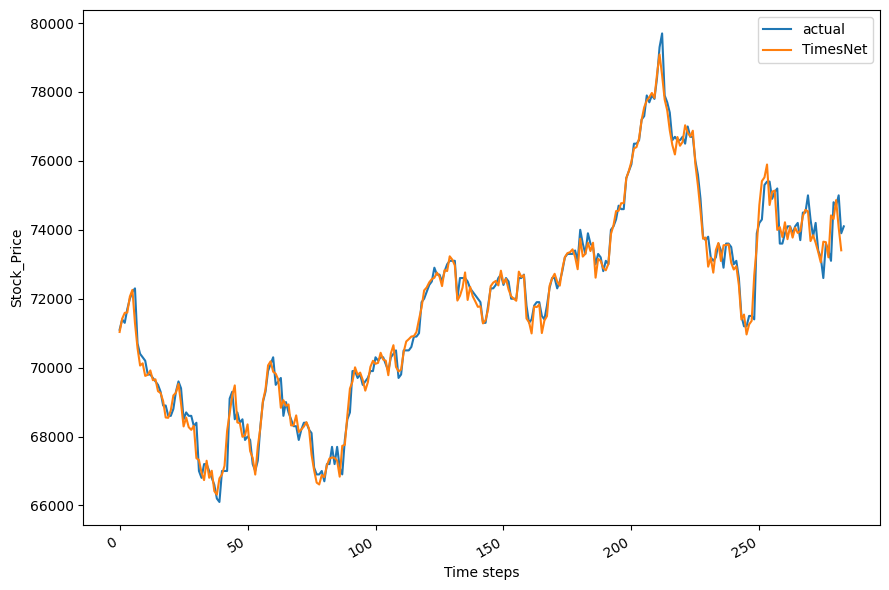

In [ ]:
fig, ax = plt.subplots()

ax.plot(preds_df['y'], label='actual')
ax.plot(preds_df['TimesNet'], label='TimesNet')

ax.legend(loc='best')
ax.set_xlabel('Time steps')
ax.set_ylabel('Stock_Price')

fig.autofmt_xdate()
plt.tight_layout()

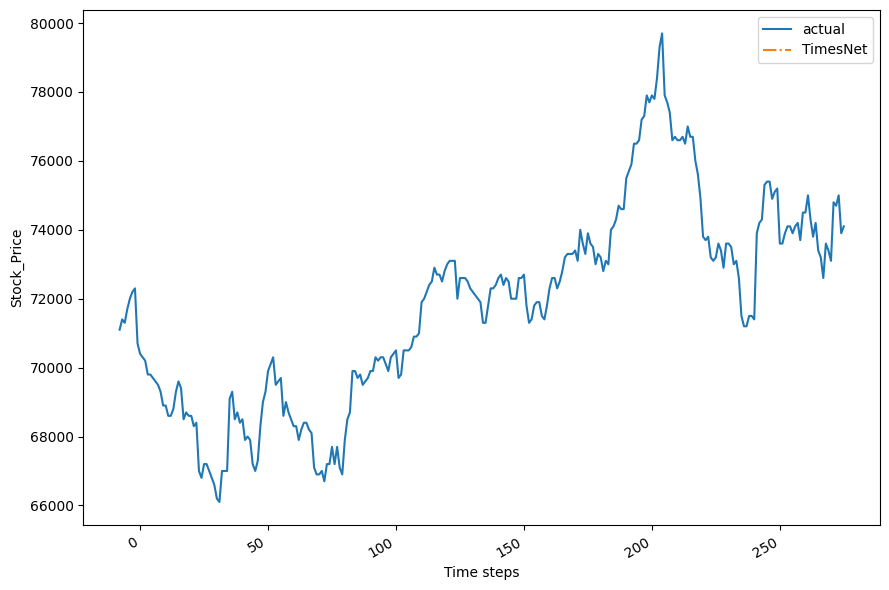

In [ ]:
fig, ax = plt.subplots()
ax.plot(preds_df['y'], label='actual')
ax.plot(Y_hat_df['TimesNet'], label='TimesNet', ls='-.')

ax.legend(loc='best')
ax.set_xlabel('Time steps')
ax.set_ylabel('Stock_Price')

fig.autofmt_xdate()
plt.tight_layout()

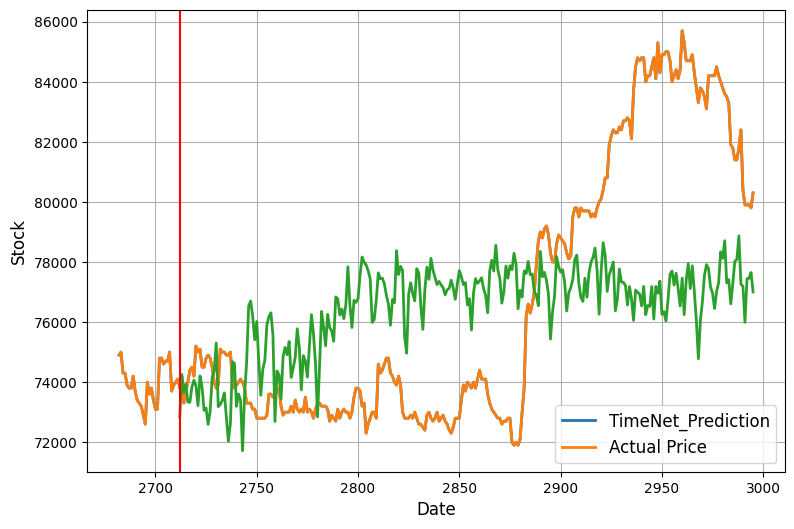

In [ ]:
### 최종 결과
# Y_hat_df = nf.predict(futr_df = f_data)
# Y_hat_df = Y_hat_df.reset_index(drop=False)

plot_df = data[data['unique_id']=='BE'].tail(10*3).reset_index(drop=True)
Y_hat_df = Y_hat_df[Y_hat_df['unique_id']=='BE']
plot_df = pd.concat([plot_df,actual ,Y_hat_df ]).set_index('ds') # Concatenate the train and forecast dataframes
# 각 변수에 대한 선의 색상을 지정하여 그래프를 그립니다.


plot_df[['y','y','TimesNet']].plot(linewidth=2, label=['Actual Price', 'TimeNet_Prediction'])
plt.axvline(actual['ds'].iloc[0], color='red')
plt.ylabel('Stock', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(['TimeNet_Prediction','Actual Price'], fontsize=12)
plt.grid()

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:746: UserWarning: Dropped 278 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
/usr/local/lib/python3.10/dist-packages/neuralforecast/tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


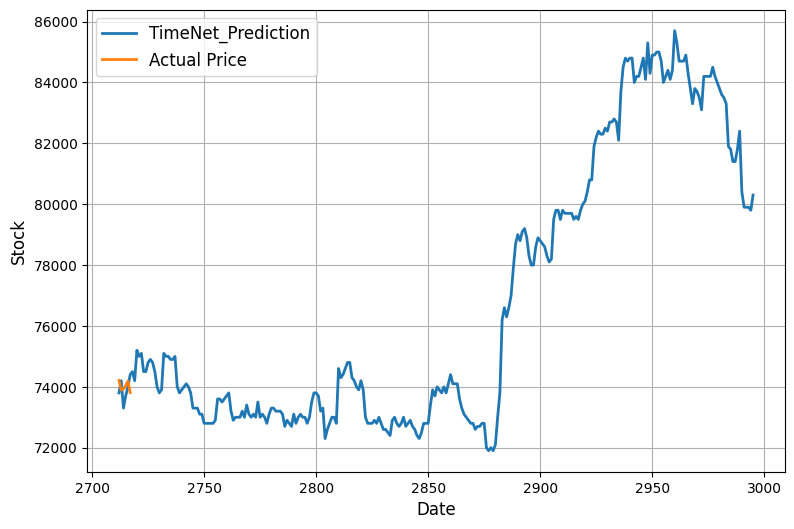

In [ ]:
### 최종 결과
Y_hat_df = nf.predict(futr_df = f_data)
Y_hat_df = Y_hat_df.reset_index(drop=False)

Y_hat_df = Y_hat_df[Y_hat_df['unique_id']=='BE']
plot_df = pd.concat([f_data ,Y_hat_df ]).set_index('ds') # Concatenate the train and forecast dataframes
# 각 변수에 대한 선의 색상을 지정하여 그래프를 그립니다.

plot_df[['y','TimesNet']].plot(linewidth=2, label=['Actual Price', 'TimeNet_Prediction'])
# plt.axvline(actual['ds'].iloc[0], color='red')
plt.ylabel('Stock', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(['TimeNet_Prediction','Actual Price'], fontsize=12)
plt.grid()

In [ ]:
Y_hat_df

,unique_id,ds,TimesNet
0,BE,2712,74208.953125
1,BE,2713,73894.875000
2,BE,2714,73925.898438
3,BE,2715,74039.140625
4,BE,2716,74188.843750
5,BE,2717,73809.210938


In [ ]:
street = '서울시'
st = '아파트'
rooms = 3
print(street,'에 위치한 아주 좋은',st,rooms)

서울시 에 위치한 아주 좋은 아파트 3
